# Project 1 CNN --- train part

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060 Ti


In [2]:
# Set the hyperparameters
learning_rate = 0.0001
batch_size = 100
num_epochs = 80

## Data exploration

In [4]:
from numpy.random.mtrand import normal
# From pytorch dataset
aug2_transform = transforms.Compose([transforms.RandomRotation(degrees=18, fill=(0,)),
                                     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])

aug_transform = transforms.Compose([transforms.RandAugment(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

normal_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

whole_train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, transform=aug_transform, download=True)
test_train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, transform=normal_transform, download=True)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, transform=normal_transform, download=True)

100%|█████████████████████████████████████████████████████████████████| 18165135/18165135 [00:10<00:00, 1803084.12it/s]


Extracting ./data\KMNIST\raw\train-images-idx3-ubyte.gz to ./data\KMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 29497/29497 [00:00<00:00, 83994.69it/s]


Extracting ./data\KMNIST\raw\train-labels-idx1-ubyte.gz to ./data\KMNIST\raw



100%|████████████████████████████████████████████████████████████████████| 3041136/3041136 [00:03<00:00, 789664.44it/s]


Extracting ./data\KMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\KMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5120/5120 [00:00<?, ?it/s]

Extracting ./data\KMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\KMNIST\raw



In [5]:
## Split train dataset for validation (Uncomment this cell if you need)

# num_train = len(whole_train_dataset)
# indices = list(range(num_train))
# val_size = 10000

# val_idx = np.random.choice(indices, size=val_size, replace=False)
# train_idx = list(set(indices) - set(val_idx))

# train_sampler = SubsetRandomSampler(train_idx)
# val_sampler = SubsetRandomSampler(val_idx

# val_loader = torch.utils.data.DataLoader(whole_train_dataset,
#                                          batch_size=batch_size,
#                                          num_workers=2,
#                                          sampler=val_sampler)

In [6]:
# Create Dataloader
train_loader = torch.utils.data.DataLoader(whole_train_dataset,
                                           batch_size=batch_size,
                                           num_workers=2)
                                           # sampler=train_sampler) 

## Uncomment this train loader if you use validation
# train_loader = torch.utils.data.DataLoader(whole_train_dataset,
#                                            batch_size=batch_size,
#                                            num_workers=2,
#                                            sampler=train_sampler) 

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=len(test_dataset),
                                          num_workers=2,
                                          shuffle=True)

test_train_loader = torch.utils.data.DataLoader(test_train_dataset,
                                                batch_size=len(test_train_dataset),
                                                num_workers=2)

torch.Size([100, 1, 28, 28])


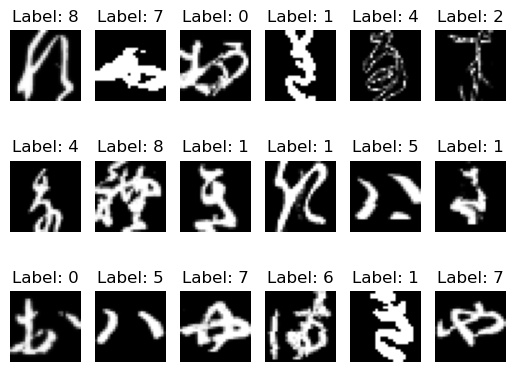

In [8]:
# Visualization of dataset, see the augmentation
batch_idx, (data, target) = next(enumerate(train_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
  plt.subplot(3, 6, i+1)
  plt.imshow(data[i][0], cmap='gray')
  plt.title('Label: {}'.format(target[i]))
  plt.axis(False)

## Model design

In [40]:
# Traditional CNN
class Cnn_mnist_v2(nn.Module):
    '''
    Convolution neural net work with 2 convolution layers and 2 fully connected layers.
    '''

    def __init__(self):
        super(Cnn_mnist_v2, self).__init__()
        # Convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.mp2 = nn.MaxPool2d(4)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.3)
        self.conv3 = nn.Conv2d(128, 200, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(200)
        self.conv3_drop = nn.Dropout2d(0.3)

        # Fully connect layer
        self.fc1 = nn.Linear(1800, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp1(self.conv1_drop(self.bn1(self.conv1(x)))))
        x = F.relu(self.mp2(self.conv2_drop(self.bn2(self.conv2(x)))))
        x = F.relu(self.conv3_drop(self.bn3(self.conv3(x))))
        x = x.view(in_size, -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [41]:
# Validate the availibility of model
batch_idx, (data, target) = next(enumerate(train_loader, 0))
model = Cnn_mnist()
outputs = model(data)

print(data.shape)
print(outputs.shape)
print(model)

torch.Size([100, 1, 28, 28])
torch.Size([100, 10])
Cnn_mnist(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (mp2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.3, inplace=False)
  (conv3): Conv2d(128, 200, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=1800, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, tra

In [42]:
def get_parameter_number(model):
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
   
    print(f'\nTotal params: {total_num}, Trainable params: {trainable_num}')

get_parameter_number(model)

conv1.weight : torch.Size([64, 1, 5, 5])
conv1.bias : torch.Size([64])
bn1.weight : torch.Size([64])
bn1.bias : torch.Size([64])
conv2.weight : torch.Size([128, 64, 3, 3])
conv2.bias : torch.Size([128])
bn2.weight : torch.Size([128])
bn2.bias : torch.Size([128])
conv3.weight : torch.Size([200, 128, 3, 3])
conv3.bias : torch.Size([200])
bn3.weight : torch.Size([200])
bn3.bias : torch.Size([200])
fc1.weight : torch.Size([256, 1800])
fc1.bias : torch.Size([256])
bn4.weight : torch.Size([256])
bn4.bias : torch.Size([256])
fc2.weight : torch.Size([10, 256])
fc2.bias : torch.Size([10])

Total params: 771042, Trainable params: 771042


In [56]:
# Inception CNN
class Inception(nn.Module):
    '''
    Inception helper for building inception layer.
    Output channels: 88
    '''
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
        
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)

# Version 2
class Inception_mnist_v2(nn.Module):
    '''
    Convolution neural network with 2 convolution layers connected with a inception layer.
    Two fully connected layers for output.
    '''
    def __init__(self):
        super(Inception_mnist_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.incept1 = Inception(in_channels=64)
        self.bn2 = nn.BatchNorm2d(88)
        self.conv2 = nn.Conv2d(88, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.incept2 = Inception(in_channels=128)
        self.bn4 = nn.BatchNorm2d(88)
        
        self.mp = nn.MaxPool2d(2)
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(4312, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv_drop(self.bn1(self.conv1(x)))))
        x = self.conv_drop(self.bn2(self.incept1(x)))
        x = F.relu(self.mp(self.bn3(self.conv_drop(self.conv2(x)))))
        x = self.conv_drop(self.bn4(self.incept2(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
# Version 3
class Inception_mnist_v3(nn.Module):
    '''
    Convolution neural network with 2 convolution layers connected with a inception layer.
    Two fully connected layers for output.
    '''
    def __init__(self):
        super(Inception_mnist_v3, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.incept1 = Inception(in_channels=64)
        self.bn2 = nn.BatchNorm2d(88)
        self.conv2 = nn.Conv2d(88, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.incept2 = Inception(in_channels=128)
        self.bn4 = nn.BatchNorm2d(88)
        self.conv3 = nn.Conv2d(88, 200, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(200)
        
        self.mp = nn.MaxPool2d(2)
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(9800, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv_drop(self.bn1(self.conv1(x)))))
        x = self.conv_drop(self.bn2(self.incept1(x)))
        x = F.relu(self.mp(self.bn3(self.conv_drop(self.conv2(x)))))
        x = self.conv_drop(self.bn4(self.incept2(x)))
        x = F.relu(self.bn5(self.conv_drop(self.conv3(x))))
        x = x.view(in_size, -1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [57]:
# Validate the availibility of model
batch_idx, (data, target) = next(enumerate(train_loader, 0))
model = Inception_mnist_v3()
outputs = model(data)

print(data.shape)
print(outputs.shape)
print(model)

torch.Size([100, 1, 28, 28])
torch.Size([100, 10])
Inception_mnist_v3(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (incept1): Inception(
    (branch1x1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch_pool): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn2): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(88, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentu

In [58]:
get_parameter_number(model)

conv1.weight : torch.Size([64, 1, 5, 5])
conv1.bias : torch.Size([64])
bn1.weight : torch.Size([64])
bn1.bias : torch.Size([64])
incept1.branch1x1.weight : torch.Size([16, 64, 1, 1])
incept1.branch1x1.bias : torch.Size([16])
incept1.branch5x5_1.weight : torch.Size([16, 64, 1, 1])
incept1.branch5x5_1.bias : torch.Size([16])
incept1.branch5x5_2.weight : torch.Size([24, 16, 5, 5])
incept1.branch5x5_2.bias : torch.Size([24])
incept1.branch_pool.weight : torch.Size([24, 64, 1, 1])
incept1.branch_pool.bias : torch.Size([24])
incept1.branch3x3_1.weight : torch.Size([16, 64, 1, 1])
incept1.branch3x3_1.bias : torch.Size([16])
incept1.branch3x3_2.weight : torch.Size([24, 16, 3, 3])
incept1.branch3x3_2.bias : torch.Size([24])
incept1.branch3x3_3.weight : torch.Size([24, 24, 3, 3])
incept1.branch3x3_3.bias : torch.Size([24])
bn2.weight : torch.Size([88])
bn2.bias : torch.Size([88])
conv2.weight : torch.Size([128, 88, 3, 3])
conv2.bias : torch.Size([128])
bn3.weight : torch.Size([128])
bn3.bias : t

## Model training

In [48]:
# Function for trainig
def train_model(model, model_name, train_loader, val_loader, epochs, optimizer, criterion, validation=True, visualization=False, early_stop=True, save_model=True):

    model.to(device)
    print('================================================================')
    train_step = len(train_loader)
    val_step = len(val_loader)
    total_loss_train = []
    total_acc_train = []
    total_loss_val = []
    total_acc_val = []
    best_acc = -float('inf')

    # Early stop step
    if early_stop:
        patience = 4
        best_loss = float('inf')
        cnt = 0
        min_delta = 0.0005

    for epoch in range(epochs):
        running_loss = 0
        running_acc = 0
        # Training step
        model.train()
        start = time.time()
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_loss = criterion(outputs, targets)
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
            running_acc += (targets==predicted).sum().item()
            
        end = time.time()
        epoch_loss = running_loss / train_step
        epoch_acc = 100 / batch_size * running_acc / train_step
        total_loss_train.append(epoch_loss)
        total_acc_train.append(epoch_acc)
        
        
        print('Epoch {} (time usage: {:.2f}s):'.format(epoch+1, end - start))
        print('Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))

        # Evaluate in validation set
        if validation:
            model.eval()
            with torch.no_grad():
                running_loss = 0
                running_acc = 0
                total = 0
                for idx, (inputs, targets) in enumerate(val_loader):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)

                    val_loss = criterion(outputs, targets)
                    total += targets.size(0)
                    running_acc += (predicted == targets).sum().item()
                    running_loss += val_loss.item()
            epoch_loss = running_loss / val_step
            epoch_acc = 100.0 * running_acc / total
            total_loss_val.append(epoch_loss)
            total_acc_val.append(epoch_acc)
            print('Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))
            
            if save_model:
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), './model/{}.pth'.format(model_name))
                
        
        

        print('================================================================')

        # Whether early top
        if early_stop:
            if  epoch_loss < best_loss - min_delta:
                best_loss = epoch_loss
                cnt = 0
            else:
                cnt += 1
            if cnt >= patience:
                break


    # Visualization
    if visualization:
        plt.figure(figsize=(14, 5))
        plt.subplot(121)
        plt.plot(total_loss_train, label='train loss')
        if validation:
            plt.plot(total_loss_val, label='validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(122)
        plt.plot(total_acc_train, label='train acc')
        if validation:
            plt.plot(total_acc_val, label='validation acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value / %')
        plt.legend()

        plt.show()


Epoch 1 (time usage: 13.53s):
Loss: 0.8039, Accuracy: 74.48%
Val_Loss: 0.4235, Val_Accuracy: 86.51%
Epoch 2 (time usage: 13.19s):
Loss: 0.3767, Accuracy: 88.54%
Val_Loss: 0.2737, Val_Accuracy: 91.44%
Epoch 3 (time usage: 13.27s):
Loss: 0.3007, Accuracy: 90.86%
Val_Loss: 0.2411, Val_Accuracy: 92.78%
Epoch 4 (time usage: 13.32s):
Loss: 0.2602, Accuracy: 92.07%
Val_Loss: 0.2102, Val_Accuracy: 93.60%
Epoch 5 (time usage: 13.48s):
Loss: 0.2372, Accuracy: 92.79%
Val_Loss: 0.1936, Val_Accuracy: 94.11%
Epoch 6 (time usage: 13.65s):
Loss: 0.2245, Accuracy: 93.10%
Val_Loss: 0.1871, Val_Accuracy: 94.29%
Epoch 7 (time usage: 13.47s):
Loss: 0.2038, Accuracy: 93.81%
Val_Loss: 0.1730, Val_Accuracy: 94.71%
Epoch 8 (time usage: 13.42s):
Loss: 0.1957, Accuracy: 94.02%
Val_Loss: 0.1532, Val_Accuracy: 95.36%
Epoch 9 (time usage: 13.42s):
Loss: 0.1867, Accuracy: 94.36%
Val_Loss: 0.1477, Val_Accuracy: 95.60%
Epoch 10 (time usage: 13.39s):
Loss: 0.1812, Accuracy: 94.53%
Val_Loss: 0.1443, Val_Accuracy: 95.62%

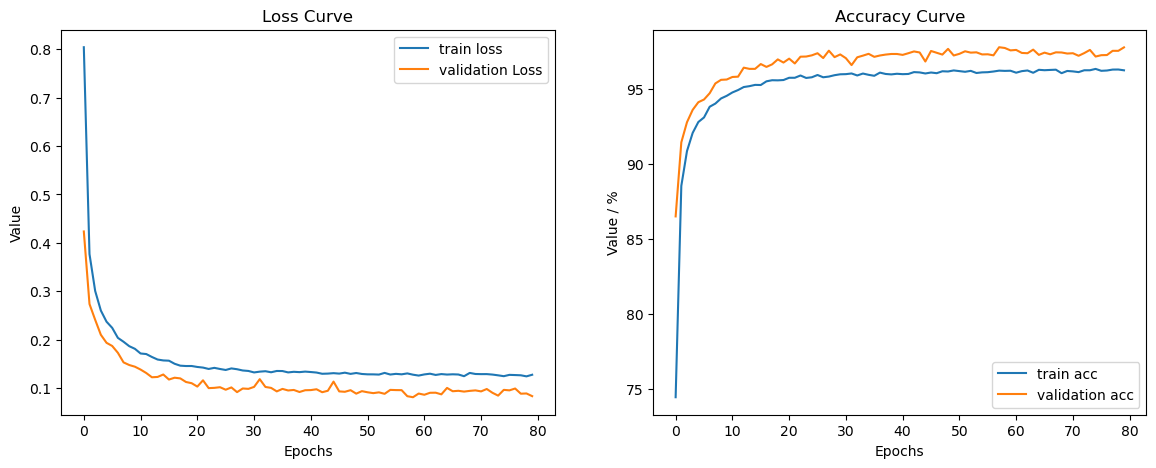

In [49]:
# Classic model
cnn_model = Cnn_mnist_v2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005, betas=(0.9,0.99), eps=1e-08, weight_decay=0.001)

train_model(model=cnn_model,
            model_name='Classic_cnn_v2',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 13.79s):
Loss: 0.9681, Accuracy: 71.26%
Val_Loss: 0.6210, Val_Accuracy: 80.85%
Epoch 2 (time usage: 13.74s):
Loss: 0.5054, Accuracy: 85.84%
Val_Loss: 0.4300, Val_Accuracy: 86.91%
Epoch 3 (time usage: 13.87s):
Loss: 0.3853, Accuracy: 89.15%
Val_Loss: 0.3428, Val_Accuracy: 89.48%
Epoch 4 (time usage: 13.80s):
Loss: 0.3192, Accuracy: 91.05%
Val_Loss: 0.2888, Val_Accuracy: 91.09%
Epoch 5 (time usage: 13.79s):
Loss: 0.2774, Accuracy: 92.09%
Val_Loss: 0.2462, Val_Accuracy: 92.43%
Epoch 6 (time usage: 13.67s):
Loss: 0.2452, Accuracy: 92.96%
Val_Loss: 0.2176, Val_Accuracy: 93.44%
Epoch 7 (time usage: 13.72s):
Loss: 0.2243, Accuracy: 93.55%
Val_Loss: 0.2001, Val_Accuracy: 93.98%
Epoch 8 (time usage: 13.77s):
Loss: 0.2043, Accuracy: 94.15%
Val_Loss: 0.1817, Val_Accuracy: 94.61%
Epoch 9 (time usage: 13.79s):
Loss: 0.1900, Accuracy: 94.60%
Val_Loss: 0.1721, Val_Accuracy: 94.92%
Epoch 10 (time usage: 13.79s):
Loss: 0.1783, Accuracy: 94.90%
Val_Loss: 0.1579, Val_Accuracy: 95.39%

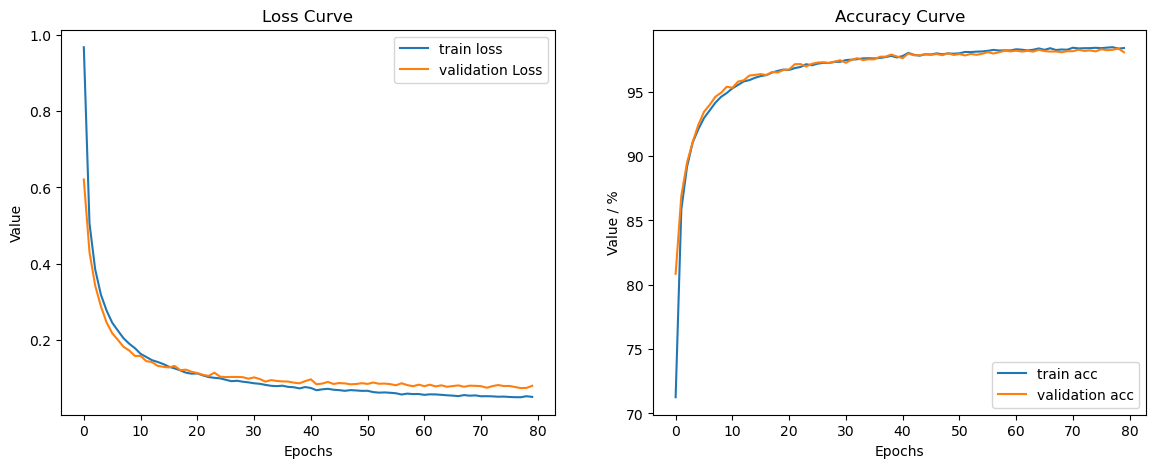

In [50]:
# Inception model with lr=0.0001
cnn_model = Inception_mnist_v2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-08, weight_decay=0)

train_model(model=cnn_model,
            model_name='Inception_cnn_v2',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 14.43s):
Loss: 0.6189, Accuracy: 81.36%
Val_Loss: 0.3414, Val_Accuracy: 89.62%
Epoch 2 (time usage: 14.06s):
Loss: 0.2898, Accuracy: 91.44%
Val_Loss: 0.2475, Val_Accuracy: 92.68%
Epoch 3 (time usage: 13.99s):
Loss: 0.2160, Accuracy: 93.56%
Val_Loss: 0.1850, Val_Accuracy: 94.31%
Epoch 4 (time usage: 13.73s):
Loss: 0.1790, Accuracy: 94.72%
Val_Loss: 0.1669, Val_Accuracy: 95.03%
Epoch 5 (time usage: 13.95s):
Loss: 0.1566, Accuracy: 95.28%
Val_Loss: 0.1492, Val_Accuracy: 95.58%
Epoch 6 (time usage: 13.82s):
Loss: 0.1422, Accuracy: 95.67%
Val_Loss: 0.1484, Val_Accuracy: 95.90%
Epoch 7 (time usage: 13.70s):
Loss: 0.1276, Accuracy: 96.09%
Val_Loss: 0.1353, Val_Accuracy: 96.32%
Epoch 8 (time usage: 13.85s):
Loss: 0.1209, Accuracy: 96.39%
Val_Loss: 0.1325, Val_Accuracy: 96.52%
Epoch 9 (time usage: 13.89s):
Loss: 0.1155, Accuracy: 96.45%
Val_Loss: 0.1220, Val_Accuracy: 96.68%
Epoch 10 (time usage: 13.80s):
Loss: 0.1070, Accuracy: 96.72%
Val_Loss: 0.1135, Val_Accuracy: 96.92%

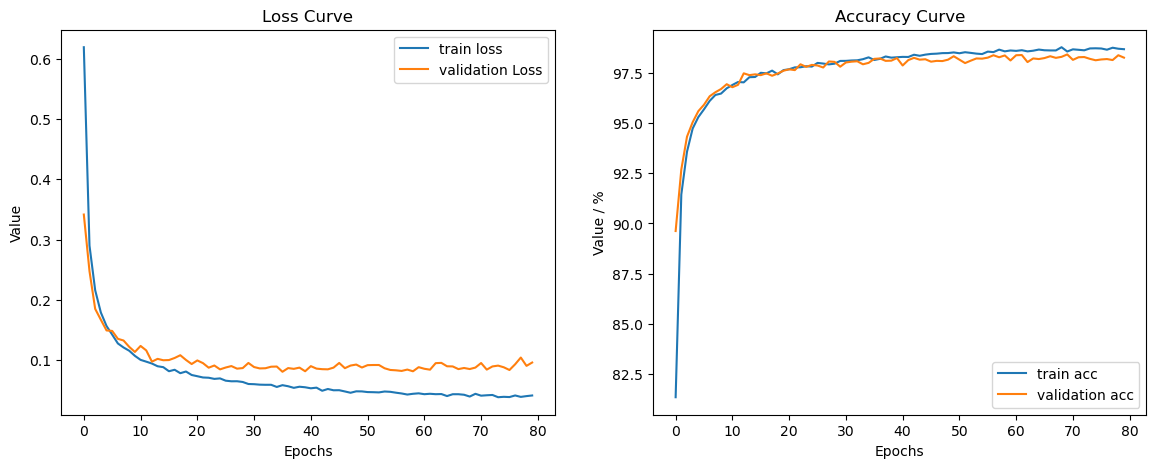

In [51]:
# Inception model with lr=0.0005
cnn_model = Inception_mnist_v2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005, betas=(0.9,0.999), eps=1e-08, weight_decay=0)

train_model(model=cnn_model,
            model_name='Inception_cnn_v2',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 13.94s):
Loss: 0.5311, Accuracy: 83.89%
Val_Loss: 0.3091, Val_Accuracy: 90.05%
Epoch 2 (time usage: 13.57s):
Loss: 0.2460, Accuracy: 92.53%
Val_Loss: 0.2348, Val_Accuracy: 92.95%
Epoch 3 (time usage: 13.74s):
Loss: 0.1924, Accuracy: 94.14%
Val_Loss: 0.1804, Val_Accuracy: 94.74%
Epoch 4 (time usage: 13.59s):
Loss: 0.1649, Accuracy: 94.97%
Val_Loss: 0.1663, Val_Accuracy: 95.20%
Epoch 5 (time usage: 13.83s):
Loss: 0.1458, Accuracy: 95.51%
Val_Loss: 0.1586, Val_Accuracy: 95.52%
Epoch 6 (time usage: 13.72s):
Loss: 0.1336, Accuracy: 95.94%
Val_Loss: 0.1245, Val_Accuracy: 96.41%
Epoch 7 (time usage: 13.55s):
Loss: 0.1211, Accuracy: 96.25%
Val_Loss: 0.1225, Val_Accuracy: 96.80%
Epoch 8 (time usage: 13.62s):
Loss: 0.1169, Accuracy: 96.36%
Val_Loss: 0.1256, Val_Accuracy: 96.77%
Epoch 9 (time usage: 13.73s):
Loss: 0.1081, Accuracy: 96.66%
Val_Loss: 0.1329, Val_Accuracy: 96.50%
Epoch 10 (time usage: 13.64s):
Loss: 0.1041, Accuracy: 96.78%
Val_Loss: 0.1205, Val_Accuracy: 96.96%

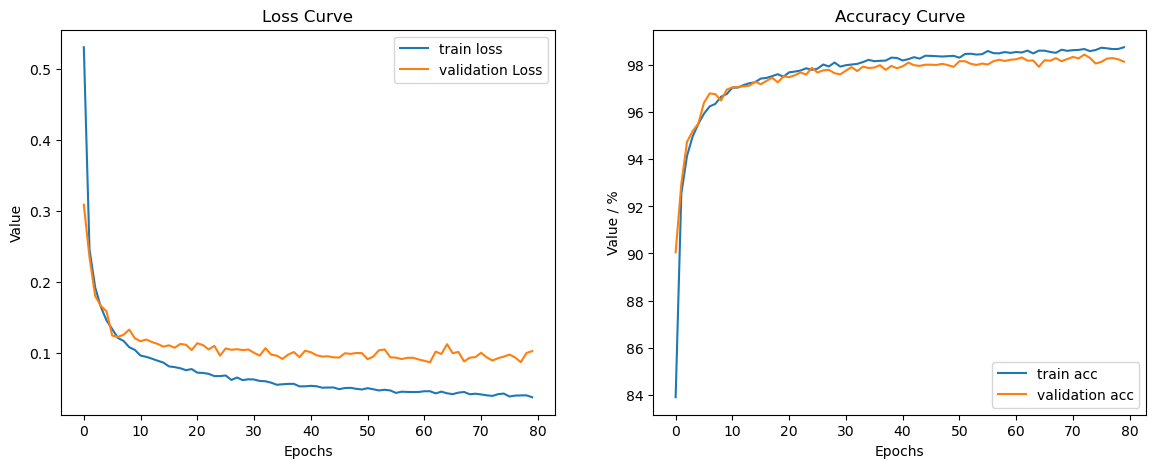

In [60]:
# Inception model with lr=0.001
cnn_model = Inception_mnist_v2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0)

train_model(model=cnn_model,
            model_name='Inception_cnn_v2',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 14.03s):
Loss: 0.5871, Accuracy: 81.83%
Val_Loss: 0.3190, Val_Accuracy: 90.09%
Epoch 2 (time usage: 13.71s):
Loss: 0.2442, Accuracy: 92.57%
Val_Loss: 0.2314, Val_Accuracy: 93.09%
Epoch 3 (time usage: 13.71s):
Loss: 0.1827, Accuracy: 94.41%
Val_Loss: 0.1748, Val_Accuracy: 94.99%
Epoch 4 (time usage: 13.71s):
Loss: 0.1521, Accuracy: 95.28%
Val_Loss: 0.1848, Val_Accuracy: 94.94%
Epoch 5 (time usage: 13.89s):
Loss: 0.1326, Accuracy: 95.84%
Val_Loss: 0.1449, Val_Accuracy: 96.28%
Epoch 6 (time usage: 13.64s):
Loss: 0.1214, Accuracy: 96.25%
Val_Loss: 0.1378, Val_Accuracy: 96.46%
Epoch 7 (time usage: 13.72s):
Loss: 0.1113, Accuracy: 96.54%
Val_Loss: 0.1483, Val_Accuracy: 96.25%
Epoch 8 (time usage: 13.72s):
Loss: 0.1029, Accuracy: 96.75%
Val_Loss: 0.1336, Val_Accuracy: 96.35%
Epoch 9 (time usage: 13.74s):
Loss: 0.0931, Accuracy: 97.13%
Val_Loss: 0.1285, Val_Accuracy: 96.74%
Epoch 10 (time usage: 13.83s):
Loss: 0.0909, Accuracy: 97.11%
Val_Loss: 0.1216, Val_Accuracy: 96.93%

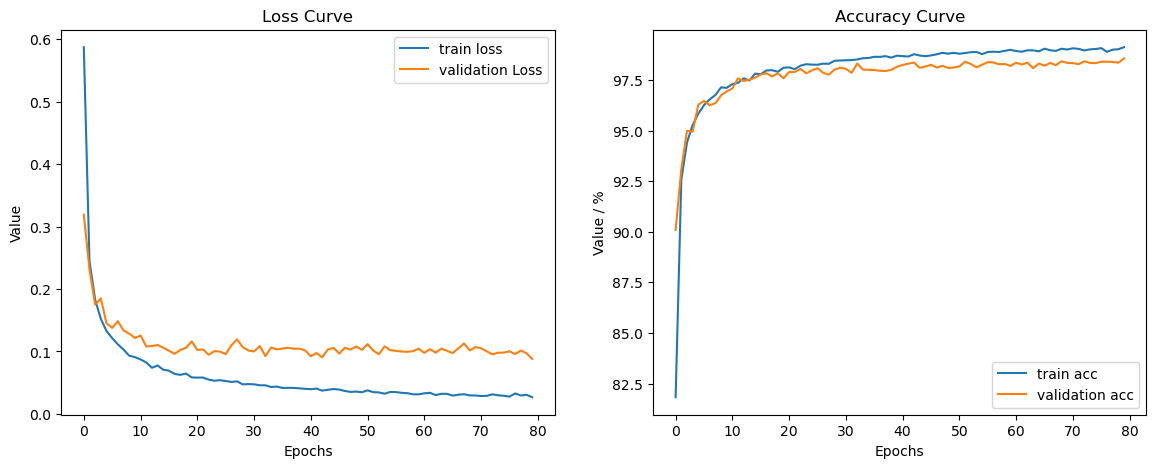

In [59]:
# Inception model
cnn_model = Inception_mnist_v3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005, betas=(0.9,0.999), eps=1e-08, weight_decay=0)

train_model(model=cnn_model,
            model_name='Inception_cnn_v3',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 13.87s):
Loss: 0.5703, Accuracy: 82.44%
Val_Loss: 0.3115, Val_Accuracy: 90.19%
Epoch 2 (time usage: 13.78s):
Loss: 0.2324, Accuracy: 92.98%
Val_Loss: 0.2118, Val_Accuracy: 93.66%
Epoch 3 (time usage: 13.86s):
Loss: 0.1770, Accuracy: 94.65%
Val_Loss: 0.1841, Val_Accuracy: 94.67%
Epoch 4 (time usage: 13.86s):
Loss: 0.1493, Accuracy: 95.34%
Val_Loss: 0.1599, Val_Accuracy: 95.78%
Epoch 5 (time usage: 14.08s):
Loss: 0.1271, Accuracy: 96.01%
Val_Loss: 0.1557, Val_Accuracy: 95.87%
Epoch 6 (time usage: 13.98s):
Loss: 0.1170, Accuracy: 96.36%
Val_Loss: 0.1398, Val_Accuracy: 96.40%
Epoch 7 (time usage: 14.04s):
Loss: 0.1077, Accuracy: 96.61%
Val_Loss: 0.1350, Val_Accuracy: 96.59%
Epoch 8 (time usage: 13.96s):
Loss: 0.0999, Accuracy: 96.91%
Val_Loss: 0.1162, Val_Accuracy: 97.22%
Epoch 9 (time usage: 13.85s):
Loss: 0.0940, Accuracy: 97.04%
Val_Loss: 0.1301, Val_Accuracy: 96.96%
Epoch 10 (time usage: 13.94s):
Loss: 0.0877, Accuracy: 97.21%
Val_Loss: 0.1170, Val_Accuracy: 97.27%

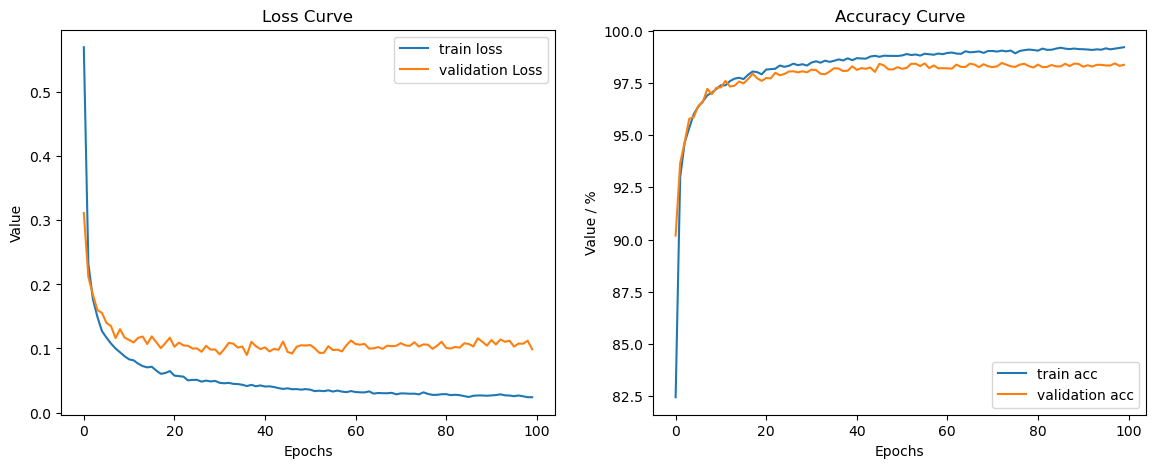

In [62]:
# Inception model
cnn_model = Inception_mnist_v3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005, betas=(0.9,0.999), eps=1e-08, weight_decay=0)

train_model(model=cnn_model,
            model_name='Inception_cnn_v3_2',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=100,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

In [16]:
# cnn_model = Cnn_mnist()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.99), eps=1e-08, weight_decay=0.001)

# train_model(model=cnn_model,
#             train_loader=train_loader,
#             val_loader=test_loader,
#             epochs=num_epochs,
#             optimizer=optimizer,
#             criterion=criterion,
#             visualization=True, early_stop=False)

In [17]:
# cnn_model = Cnn_mnist()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-08, weight_decay=0.000)

# train_model(model=cnn_model,
#             train_loader=train_loader,
#             val_loader=test_loader,
#             epochs=num_epochs,
#             optimizer=optimizer,
#             criterion=criterion,
#             visualization=True, early_stop=False)

In [18]:
# train_model(model=cnn_model,
#             train_loader=train_loader,
#             val_loader=test_loader,
#             epochs=num_epochs,
#             optimizer=optimizer,
#             criterion=criterion,
#             visualization=True, early_stop=False)

In [19]:
# cnn_model = Cnn_mnist()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.LBFGS(cnn_model.parameters(), line_search_fn='strong_wolfe')

# train_model(model=cnn_model,
#             train_loader=train_loader,
#             val_loader=test_loader,
#             epochs=20,
#             optimizer=optimizer,
#             criterion=criterion,
#             visualization=True, early_stop=False)

In [20]:


# def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, validation=True, visualization=False, early_stop=True):

#     model.to(device)
#     print('================================================================')
#     train_step = len(train_loader)
#     val_step = len(val_loader)
#     total_loss_train = []
#     total_acc_train = []
#     total_loss_val = []
#     total_acc_val = []

#     # Early stop step
#     if early_stop:
#         patience = 4
#         best_loss = float('inf')
#         cnt = 0
#         min_delta = 0.0005

#     for epoch in range(epochs):
#         running_loss = 0
#         running_acc = 0
#         # Training step
#         model.train()
#         start = time.time()
        
#         for idx, (inputs, targets) in enumerate(train_loader):
#             inputs = inputs.to(device)
#             targets = targets.to(device)
#             # optimizer.zero_grad()
#             def closure():
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 return loss

#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             train_loss = criterion(outputs, targets)
#             # train_loss.backward()
#             optimizer.step(closure)

#             running_loss += train_loss.item()
#             running_acc += (targets==predicted).sum().item()
            
#         end = time.time()
#         epoch_loss = running_loss / train_step
#         epoch_acc = 100 / batch_size * running_acc / train_step
#         total_loss_train.append(epoch_loss)
#         total_acc_train.append(epoch_acc)
        
        
#         print('Epoch {} (time usage: {:.2f}s):'.format(epoch+1, end - start))
#         print('Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))

#         # Evaluate in validation set
#         if validation:
#             model.eval()
#             with torch.no_grad():
#                 running_loss = 0
#                 running_acc = 0
#                 total = 0
#                 for idx, (inputs, targets) in enumerate(val_loader):
#                     inputs = inputs.to(device)
#                     targets = targets.to(device)

#                     outputs = model(inputs)
#                     _, predicted = torch.max(outputs.data, 1)

#                     val_loss = criterion(outputs, targets)
#                     total += targets.size(0)
#                     running_acc += (predicted == targets).sum().item()
#                     running_loss += val_loss.item()
#             epoch_loss = running_loss / val_step
#             epoch_acc = 100.0 * running_acc / total
#             total_loss_val.append(epoch_loss)
#             total_acc_val.append(epoch_acc)
#             print('Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))

#         print('================================================================')

#         # Whether early top
#         if early_stop:
#             if  epoch_loss < best_loss - min_delta:
#                 best_loss = epoch_loss
#                 cnt = 0
#             else:
#                 cnt += 1
#             if cnt >= patience:
#                 break


#     # Visualization
#     if visualization:
#         plt.figure(figsize=(14, 5))
#         plt.subplot(121)
#         plt.plot(total_loss_train, label='train loss')
#         if validation:
#             plt.plot(total_loss_val, label='validation Loss')
#         plt.title('Loss Curve')
#         plt.xlabel('Epochs')
#         plt.ylabel('Value')
#         plt.legend()

#         plt.subplot(122)
#         plt.plot(total_acc_train, label='train acc')
#         if validation:
#             plt.plot(total_acc_val, label='validation acc')
#         plt.title('Accuracy Curve')
#         plt.xlabel('Epochs')
#         plt.ylabel('Value / %')
#         plt.legend()

#         plt.show()


In [21]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# # Evaluation function
# def evaluate_model(model, test_loader):
#   model.eval()
#   inputs, targets = next(iter(test_loader))
#   outputs = model(inputs)
#   _, predicted = torch.max(outputs, 1)

#   print('Performance: ')
#   print(classification_report(targets, predicted))
#   print('Confusion matrix:')
#   print(confusion_matrix(targets, predicted))
#   print('\nACCURACY: {}'.format(accuracy_score(targets, predicted)))



In [22]:
# evaluate_model(cnn_model, test_loader=train_loader)